# Crime

## Setup

In [1]:
from matplotlib.colors import ListedColormap 
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
from lib import formatting as sd_formatting
import pyodbc 
import toml
import config_logging
import logging
import urllib.request
import pandas as pd
import colorcet as cc

log = logging.getLogger(__name__)
external_ip = urllib.request.urlopen('https://ident.me').read().decode('utf8')

secrets = toml.load("./.streamlit/secrets.toml")

database_toml = secrets[secrets["database"]["flavour"]] 

database_props = {
                   "driver"   : database_toml["driver"]
                 , "host"     : database_toml["host"]
                 , "port"     : database_toml["port"]
                 , "instance" : database_toml["instance"]
                 , "database" : database_toml["database"]
                 , "username" : database_toml["username"]
                 , "password" : database_toml["password"]
}
db_conn = None
## Connect to the database -- this might move to a factory method to provide the connection


def get_db_conn(database_props):
    try:                      
        db_conn = pyodbc.connect(driver   = database_props["driver"]
                               , server   = "{},{}\{}".format(database_props["host"], database_props["port"], database_props["instance"])
                               , database = database_props["database"]
                               , uid      = database_props["username"]
                               , pwd      = database_props["password"])

        log.info(f"DATABASE CONNECTIVITY from {external_ip}") 
    except Exception as e:
        log.error(f"NO DATABASE CONNECTIVITY from {external_ip}") 
        log.error(e)
        raise Exception("DATABASE CONNECTIVITY")
        
    return db_conn



2022-08-21 21:42:34,812 [INFO] numexpr.utils: NumExpr defaulting to 4 threads.


In [2]:
### Set up
%load_ext autoreload

%autoreload 3
from lib import masters_data_analytics_lib as mlib
from lib import stats as stats
from data.daos import dao_facade_local as dao_fac

db_conn = get_db_conn(database_props)


2022-08-21 21:42:38,672 [DEBUG] matplotlib.pyplot: Loaded backend module://matplotlib_inline.backend_inline version unknown.
2022-08-21 21:42:38,683 [DEBUG] matplotlib.pyplot: Loaded backend module://matplotlib_inline.backend_inline version unknown.
2022-08-21 21:42:39,266 [INFO] __main__: DATABASE CONNECTIVITY from 185.44.76.189


## Build the Data

### Search Critera & DAO Access to get all required data

In [3]:
year_from = 2010
year_to   = 2021
city      = "London"
borough   = "Islington"

# borough   = "Westminster"    # Highest
# borough   = "Brent"          # Middle
# borough   = "City of London" # Lowest


borough_crime_min_max_year_df = dao_fac.crime_min_max_year(db_conn)

borough_crime_year_min = borough_crime_min_max_year_df["MIN_YEAR"].values[0]
borough_crime_year_max = borough_crime_min_max_year_df["MAX_YEAR"].values[0]

log.debug(borough_crime_year_min)
log.debug(borough_crime_year_max)

year_from_orig = year_from
year_to_orig = year_to

if year_from < int(borough_crime_year_min):
    year_from = int(borough_crime_year_min)
elif year_from > int(borough_crime_year_max):
    year_from = int(borough_crime_year_max)

if year_to > int(borough_crime_year_max):
    year_to = int(borough_crime_year_max)
elif year_to < int(borough_crime_year_min):
    year_to = int(borough_crime_year_min)

log.debug(f"orig_year_from  :{year_from_orig}")
log.debug(f"orig_year_to    :{year_to_orig}")

log.debug(f"search_year_from:{year_from}")
log.debug(f"search_year_to  :{year_to}")

search_criteria = {"year_from":year_from,
                   "year_to":year_to,
                   "borough":borough                  }

### Now we have a date range that's validated, apply it to the crim data
log.debug("QRY Started")
borough_crime_per_capita_by_year_df = dao_fac.crime_ranked_by_borough_years(db_conn, search_criteria)
log.debug("QRY Ended")
# log.debug(borough_crime_per_capita_by_year_df)

unique_years = borough_crime_per_capita_by_year_df["YEAR"].unique().tolist()
unique_years.reverse()

## City Population
city_yearly_population_df = dao_fac.city_yearly_population(db_conn, search_criteria)

## Borough Population
borough_yearly_population_df = dao_fac.borough_yearly_population(db_conn, search_criteria)

city_yearly_population_ts_df = city_yearly_population_df.copy()
borough_yearly_population_ts_df = borough_yearly_population_df.copy()

city_yearly_population_ts_df = city_yearly_population_ts_df.set_index("YEAR")
city_yearly_population_ts_df["Year"] = city_yearly_population_ts_df.index

borough_yearly_population_ts_df = borough_yearly_population_ts_df.set_index("YEAR")
borough_yearly_population_ts_df["Year"] = borough_yearly_population_ts_df.index

# city_yearly_population_df["YEAR"] = city_yearly_population_df.index
# city_yearly_population_df

2022-08-21 21:42:39,459 [DEBUG] root: Retrieving crime min max year
2022-08-21 21:42:39,528 [DEBUG] __main__: 2001
2022-08-21 21:42:39,529 [DEBUG] __main__: 2022
2022-08-21 21:42:39,531 [DEBUG] __main__: orig_year_from  :2010
2022-08-21 21:42:39,531 [DEBUG] __main__: orig_year_to    :2021
2022-08-21 21:42:39,532 [DEBUG] __main__: search_year_from:2010
2022-08-21 21:42:39,536 [DEBUG] __main__: search_year_to  :2021
2022-08-21 21:42:39,537 [DEBUG] __main__: QRY Started
2022-08-21 21:42:39,538 [DEBUG] root: Retrieving Crime Ranked By Borough Years


C:\DISTRIBUTIONS\Python\Python3_10_2\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\DISTRIBUTIONS\Python\Python3_10_2\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


2022-08-21 21:43:19,575 [DEBUG] __main__: QRY Ended
2022-08-21 21:43:19,576 [DEBUG] root: city_population
2022-08-21 21:43:19,616 [DEBUG] root: city_population


C:\DISTRIBUTIONS\Python\Python3_10_2\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\DISTRIBUTIONS\Python\Python3_10_2\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [4]:
city_yearly_population_ts_df

,POPULATION_FOR_YEAR_CITY,Year
YEAR,,
2010,8054622.0,2010
2011,8178486.0,2011
2012,8302350.0,2012
2013,8426218.0,2013
2014,8550077.0,2014
2015,8673947.0,2015
2016,8797812.0,2016
2017,8921677.0,2017
2018,9045542.0,2018


In [5]:
borough_yearly_population_ts_df

,BOROUGH,POPULATION_FOR_YEAR_CITY,Year
YEAR,,,
2010,Islington,202849.0,2010
2011,Islington,205968.0,2011
2012,Islington,209087.0,2012
2013,Islington,212207.0,2013
2014,Islington,215326.0,2014
2015,Islington,218446.0,2015
2016,Islington,221565.0,2016
2017,Islington,224685.0,2017
2018,Islington,227804.0,2018


### Build Data For the Plot

In [6]:
index = []
data  = []
columns = ["CITY_MAX_IN_YEAR", "CITY_MEAN_IN_YEAR", "CITY_MIN_IN_YEAR", "BOROUGH_MEAN_IN_YEAR"]

for year in unique_years:
    data_row = []
    city_max_in_year     = borough_crime_per_capita_by_year_df[borough_crime_per_capita_by_year_df["YEAR"] == year]["CRIMES_PER_PERSON"].max()
    city_mean_in_year    = borough_crime_per_capita_by_year_df[borough_crime_per_capita_by_year_df["YEAR"] == year]["CRIMES_PER_PERSON"].mean()
    city_min_in_year     = borough_crime_per_capita_by_year_df[borough_crime_per_capita_by_year_df["YEAR"] == year]["CRIMES_PER_PERSON"].min()
    borough_mean_in_year = borough_crime_per_capita_by_year_df[(borough_crime_per_capita_by_year_df["YEAR"] == year) &
                                                             (borough_crime_per_capita_by_year_df["BOROUGH"] == borough)]["CRIMES_PER_PERSON"].values[0]
        
    # max_in_year_fmt          = "£{:,.0f}".format(city_max_in_year)
    # mean_in_year_fmt         = "£{:,.0f}".format(city_mean_in_year)
    # min_in_year_fmt          = "£{:,.0f}".format(city_min_in_year)
    # borough_mean_in_year_fmt = "£{:,.0f}".format(borough_mean_in_year)
    # country_mean_in_year_fmt = "£{:,.0f}".format(country_mean_in_year)
        
    index.append(year)
    data_row.append(city_max_in_year)
    data_row.append(city_mean_in_year)
    data_row.append(city_min_in_year)
    data_row.append(borough_mean_in_year)
    data.append(data_row)
    # log.debug(f"[{borough}]-{year} - borough mean:{borough_mean_in_year_fmt} - city max:{max_in_year_fmt} - city mean:{mean_in_year_fmt} - city min:{min_in_year_fmt} - country mean:{country_mean_in_year_fmt}")
    
crime_ts_df = pd.DataFrame(data=data, index=index, columns=columns)    
crime_ts_df["Year"] = crime_ts_df.index


In [7]:
crime_ts_df

,CITY_MAX_IN_YEAR,CITY_MEAN_IN_YEAR,CITY_MIN_IN_YEAR,BOROUGH_MEAN_IN_YEAR,Year
2010,0.28522,0.098684,0.0,0.13523,2010
2011,0.29466,0.096769,0.0,0.13102,2011
2012,0.27801,0.092321,0.0,0.13140,2012
2013,0.24108,0.081904,0.0,0.11423,2013
2014,0.20967,0.079822,0.0,0.11661,2014
2015,0.20626,0.082426,0.0,0.12592,2015
2016,0.20802,0.084242,0.0,0.12462,2016
2017,0.23350,0.089785,0.0,0.14255,2017
2018,0.25511,0.090055,0.0,0.12430,2018
2019,0.32528,0.097049,0.0,0.12935,2019


In [8]:
crime_changed_search_date_narrative = f"Your original search dates were changed to match the date range of the crime data. The new dates are {year_from} to {year_to}" \
                                      if ((year_from != year_from_orig) or \
                                         (year_to   != year_to_orig)) else ""

log.debug(crime_changed_search_date_narrative)

2022-08-21 21:43:20,659 [DEBUG] __main__: 


## Build the Time Series Plot

### Text Description of Plot

In [9]:
crime_plot_desctiption_year_range = f"between {year_from} and {year_to}" if year_to != year_from else f"for {year_to}"
crime_plot_description_narrative = f"The graph below compares the crimes per person in the {city} borough of {borough} {crime_plot_desctiption_year_range}."
log.debug(crime_plot_description_narrative)

2022-08-21 21:43:20,836 [DEBUG] __main__: The graph below compares the crimes per person in the London borough of Islington between 2010 and 2021.


In [10]:
crime_ts_df

,CITY_MAX_IN_YEAR,CITY_MEAN_IN_YEAR,CITY_MIN_IN_YEAR,BOROUGH_MEAN_IN_YEAR,Year
2010,0.28522,0.098684,0.0,0.13523,2010
2011,0.29466,0.096769,0.0,0.13102,2011
2012,0.27801,0.092321,0.0,0.13140,2012
2013,0.24108,0.081904,0.0,0.11423,2013
2014,0.20967,0.079822,0.0,0.11661,2014
2015,0.20626,0.082426,0.0,0.12592,2015
2016,0.20802,0.084242,0.0,0.12462,2016
2017,0.23350,0.089785,0.0,0.14255,2017
2018,0.25511,0.090055,0.0,0.12430,2018
2019,0.32528,0.097049,0.0,0.12935,2019


### Crime Time Series Plot

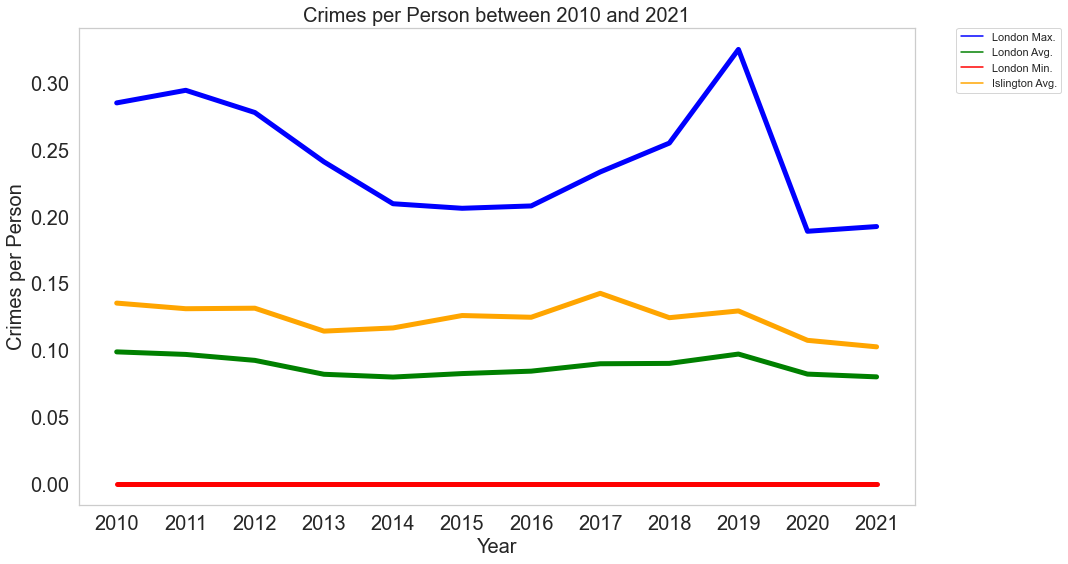

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


x_fig_size = 15
y_fig_size = 8

## Set the size
sns.set(rc={"figure.figsize":(x_fig_size, y_fig_size)})

## Set the theme
sns.set_style("whitegrid")

marker = "" if year_from != year_to else "o"

fig, ax = plt.subplots()
sns.lineplot(data=crime_ts_df, x="Year", y="CITY_MAX_IN_YEAR",     ax=ax, label=f"{city} Max.",    color='blue', marker=marker)
sns.lineplot(data=crime_ts_df, x="Year", y="CITY_MEAN_IN_YEAR",    ax=ax, label=f"{city} Avg.",    color='green', marker=marker)
sns.lineplot(data=crime_ts_df, x="Year", y="CITY_MIN_IN_YEAR",     ax=ax, label=f"{city} Min.",    color='red', marker=marker)
sns.lineplot(data=crime_ts_df, x="Year", y="BOROUGH_MEAN_IN_YEAR", ax=ax, label=f"{borough} Avg.", color='orange', marker=marker)

plot_title = "Crimes per Person between {} and {}".format(year_from, year_to) if year_from != year_to else \
             "Crimes per Person for {}".format(year_to)

ax.set_title(plot_title, fontsize=20)
ax.set_ylabel("Crimes per Person", fontsize=20)
ax.set_xlabel("Year", fontsize=20)

ax.legend(title="legend")
ax.legend(loc="upper right")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

for line in ax.get_lines():
    line.set_linewidth(5)
    line.set_ms(10)

ax.grid(False)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

# ax2 = plt.twinx()
# ax2.grid(False)
# # sns.lineplot(data=city_yearly_population_ts_df, x="Year", y="POPULATION_FOR_YEAR_CITY" , color="b", ax=ax2)
# sns.lineplot(data=borough_yearly_population_ts_df, x="Year", y="POPULATION_FOR_YEAR_CITY" , color="b", ax=ax2)

plt.tight_layout()

crime_plot = plt.gcf()

# plt.show()



### Crime Time Series Narrative

In [12]:
## The maximum year from the data set
crime_latest_year = borough_crime_per_capita_by_year_df["YEAR"].max()
crime_latest_year = year_to

## The Average earnings across all the boroughs for that year
borough_crime_ranking_filtered_max_year_df =  borough_crime_per_capita_by_year_df[borough_crime_per_capita_by_year_df["YEAR"].astype(int) == crime_latest_year]


latest_city_max_mean_crime_pp     = borough_crime_ranking_filtered_max_year_df["CRIMES_PER_PERSON"].max()
latest_city_mean_mean_crime_pp    = borough_crime_ranking_filtered_max_year_df["CRIMES_PER_PERSON"].mean()
latest_borough_mean_crime_pp      = borough_crime_ranking_filtered_max_year_df[borough_crime_ranking_filtered_max_year_df["BOROUGH"] == borough]["CRIMES_PER_PERSON"].values[0]
latest_city_min_mean_crime_pp     = borough_crime_ranking_filtered_max_year_df["CRIMES_PER_PERSON"].min()

def prepend(a, b):
  ret_val = ""
  if b != 0:
      if a > b:
        ret_val = "significantly " if a/b >= 2.0 else ""
      elif a < b:
        ret_val = "significantly " if b/a >= 2.0 else ""
  return ret_val

def above_below_equal(a, b):
    ret_val = ""
    if b != 0:
        if a > b:
            if a/b <= 1.1:
                ret_val = "comparable to"
            else:
                ret_val = "above"
        elif a < b:
            if b/a <= 1.1:
                ret_val = "comparable to"
            else:
                ret_val = "below"
        else:
            ret_val = "equal to"
    else:
        ret_val = "above"

    return ret_val

## Format the latest for the text
### City
latest_city_max_mean_crime_pp_fmt     = "{:,.4f}".format(float(latest_city_max_mean_crime_pp))
latest_city_mean_mean_crime_pp_fmt    = "{:,.4f}".format(float(latest_city_mean_mean_crime_pp))
latest_borough_mean_crime_pp_fmt      = "{:,.4f}".format(float(latest_borough_mean_crime_pp))
latest_city_min_mean_crime_pp_fmt     = "{:,.4f}".format(float(latest_city_min_mean_crime_pp))

## Preamble
part_01 = f"The {crime_latest_year} crimes per person in {borough} is {latest_borough_mean_crime_pp_fmt}"

## CITY BOROUGH MEAN COMPARE TO CITY MEAN MEAN [X]
mean_explanation = f"{prepend(latest_borough_mean_crime_pp, latest_city_mean_mean_crime_pp)}{above_below_equal(latest_borough_mean_crime_pp, latest_city_mean_mean_crime_pp)}"
part_02 = f". This is {mean_explanation} the average for {city} in the same period of {latest_city_mean_mean_crime_pp_fmt}"


# CITY BOROUGH MEAN COMPARE TO CITY MAX MEAN [X]
max_explanation = f"{prepend(latest_borough_mean_crime_pp, latest_city_max_mean_crime_pp)}{above_below_equal(latest_borough_mean_crime_pp, latest_city_max_mean_crime_pp)}"
part_03 = f" and is {max_explanation} the maximum of {latest_city_max_mean_crime_pp_fmt}"


## CITY BOROUGH MEAN COMPARE TO CITY MIN MEAN [X]
min_explanation = f"{prepend(latest_borough_mean_crime_pp, latest_city_min_mean_crime_pp)}{above_below_equal(latest_borough_mean_crime_pp, latest_city_min_mean_crime_pp)}"
part_04 = f". It is {min_explanation} the minimum of {latest_city_min_mean_crime_pp_fmt}"

from scipy import stats
y = [crime_ts_df["BOROUGH_MEAN_IN_YEAR"].tolist()]
x = crime_ts_df.index.astype(int).tolist()

part_05 = ""

if len(x) >= 3:

    # log.debug(y)
    # log.debug(x)

    slope, intercept, r, p, std_err = stats.linregress(x, y)

    if slope == 0:
        rate = "has remained level"
    elif slope > 0:    
        if slope >= 0.1:
            rate = "has slightly increased"
        elif slope >=  0.5:
            rate = "has moderatly increased"
        else:
            rate = "has greatly increased"
    else:
        if slope <= - 0.1:
            rate = "has slightly decreased"
        elif slope <= - 0.5:
            rate = "has moderatly decreased"
        else:
            rate = "has greatly decreasd"

    part_05 = f". Over the period {year_from} to {year_to} crimes per person in {borough} {rate}."

## Borough population trend 
part_06 = ""
part_07 = ""

y = [borough_yearly_population_df["POPULATION_FOR_YEAR_CITY"].tolist()]
x = borough_yearly_population_df.index.astype(int).tolist()

if len(x) >= 3:

    ## Borough population trend.
    borough_population_start = y[0][0]
    borough_population_start_fmt = "{:,.0f}".format(borough_population_start)
    
    borough_population_end = y[0][-1]
    borough_population_end_fmt = "{:,.0f}".format(borough_population_end)
    
    slope, intercept, r, p, std_err = stats.linregress(x, y)

    inc_dec_narrative = ""
    if slope == 0:
        rate = "has remained level"
    elif slope > 0:    
        inc_dec = borough_population_end - borough_population_start
        inc_dec_fmt = "{:,.0f}".format(inc_dec)
        inc_dec_narrative = f" which is an increase of {inc_dec_fmt}"
        
        if slope >= 0.1:
            rate = "has slightly increased"
        elif slope >=  0.5:
            rate = "has moderatly increased"
        else:
            rate = "has greatly increased"
    else:
        inc_dec = borough_population_start - borough_population_end 
        inc_dec_fmt = "{:,.0f}".format(inc_dec)
        inc_dec_narrative = f" which is a decrease of {inc_dec_fmt}"
        
        if slope <= - 0.1:
            rate = "has slightly decreased"
        elif slope <= - 0.5:
            rate = "has moderatly decreased"
        else:
            rate = "has greatly decreasd"

    part_06 = f" Over the same period the population of {borough} {rate} starting at {borough_population_start_fmt} and ending at {borough_population_end_fmt} {inc_dec_narrative}."

    ## City population trend
    y = [city_yearly_population_ts_df["POPULATION_FOR_YEAR_CITY"].tolist()]
    x = city_yearly_population_ts_df.index.astype(int).tolist()

    city_population_start = y[0][0]
    city_population_start_fmt = "{:,.0f}".format(city_population_start)
    
    city_population_end = y[0][-1]
    city_population_end_fmt = "{:,.0f}".format(city_population_end)
    
    slope, intercept, r, p, std_err = stats.linregress(x, y)

    inc_dec_narrative = ""
    if slope == 0:
        rate = "has remained level"
    elif slope > 0:    
        inc_dec = city_population_end - city_population_start
        inc_dec_fmt = "{:,.0f}".format(inc_dec)
        inc_dec_narrative = f" which is an increase of {inc_dec_fmt}"
        
        if slope >= 0.1:
            rate = "has slightly increased"
        elif slope >=  0.5:
            rate = "has moderatly increased"
        else:
            rate = "has greatly increased"
    else:
        inc_dec = city_population_start - city_population_end 
        inc_dec_fmt = "{:,.0f}".format(inc_dec)
        inc_dec_narrative = f" which is a decrease of {inc_dec_fmt}"
        
        if slope <= - 0.1:
            rate = "has slightly decreased"
        elif slope <= - 0.5:
            rate = "has moderatly decreased"
        else:
            rate = "has greatly decreasd"

    part_07 = f" {city}'s population {rate} from {city_population_start_fmt} and ending at {city_population_end_fmt} {inc_dec_narrative}."
    
    
    ### Put them all together  [ ]
    crime_narrative = f"\n{part_01}{part_02}{part_03}{part_04}{part_05}{part_06}{part_07}"

    log.debug(crime_narrative)


2022-08-21 21:43:25,972 [DEBUG] __main__: 
The 2021 crimes per person in Islington is 0.1025. This is above the average for London in the same period of 0.0800 and is below the maximum of 0.1926. It is above the minimum of 0.0000. Over the period 2010 to 2021 crimes per person in Islington has greatly decreasd. Over the same period the population of Islington has slightly increased starting at 202,849 and ending at 237,162  which is an increase of 34,313. London's population has slightly increased from 8,054,622 and ending at 9,417,134  which is an increase of 1,362,512.


## Build Bump Chart Plot

In [13]:
years_sorted = borough_crime_per_capita_by_year_df["YEAR"].sort_values().drop_duplicates()
first_year = years_sorted.iloc[0]
borough_sort_order = borough_crime_per_capita_by_year_df.loc[borough_crime_per_capita_by_year_df["YEAR"]==first_year]["BOROUGH"]
top_borough = borough_sort_order.iloc[0]
mid_borough = borough_sort_order.iloc[16]
bottom_borough = borough_sort_order.iloc[-1]

## Loop through the boroughs in the sort order of first year
all_borough_ranking_by_year = []

## BOROUGH LOOP
for _borough in borough_sort_order:

    borough_ranking_by_year_list = []

    ## Add the Borough
    borough_ranking_by_year_list.append(_borough)

    ## YEAR LOOP
    for year in years_sorted:

        borough_ranking_for_year = borough_crime_per_capita_by_year_df.loc[(borough_crime_per_capita_by_year_df["BOROUGH"]==_borough) &
                                      (borough_crime_per_capita_by_year_df["YEAR"]==year)]["RANK"].values[0]

        borough_ranking_by_year_list.append(borough_ranking_for_year)

    all_borough_ranking_by_year.append(borough_ranking_by_year_list)

columns = ["Borough"] + list(years_sorted)

all_borough_ranking_by_year_df = pd.DataFrame(all_borough_ranking_by_year, columns=columns).set_index("Borough")

tmb_borough_ranking_by_year_df = all_borough_ranking_by_year_df.copy()


### Crime Time Series Bump Chart Narrative

In [14]:
crime_bump_chart_date_range = f"over the period {year_from} to {year_to}" if year_from != year_to else f"for {year_to}"

crime_bump_chart_narrative = f"How {borough} ranks with the other London boroughs {crime_bump_chart_date_range} can be seen below. Ranking is top to bottom, with the top representing the highest crimes per person rate."
log.debug(f"\n{crime_bump_chart_narrative}")

2022-08-21 21:43:26,801 [DEBUG] __main__: 
How Islington ranks with the other London boroughs over the period 2010 to 2021 can be seen below. Ranking is top to bottom, with the top representing the highest crimes per person rate.


### Earnings Time Series Bump Chart

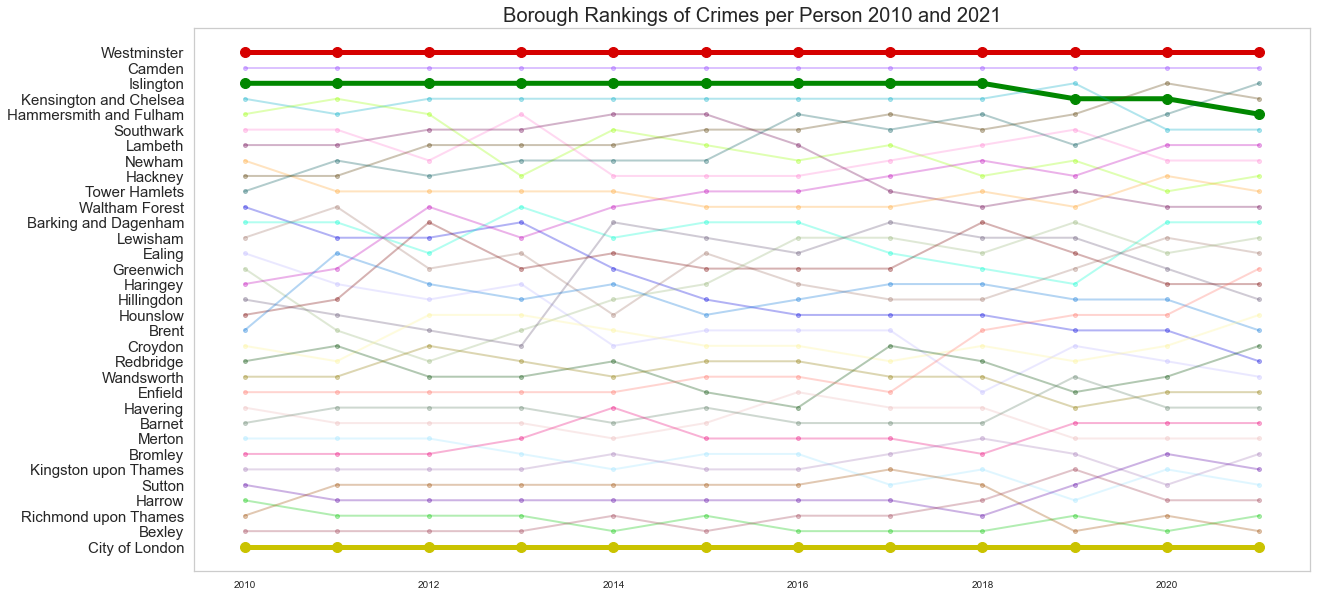

In [15]:
####
#### CREATE THE PLOTS - APPENDICES VERSION
#### 

palette = sns.color_palette(cc.glasbey, n_colors=len(borough_sort_order))
my_cmap = ListedColormap(sns.color_palette(palette).as_hex())
ax = all_borough_ranking_by_year_df.T.plot(figsize=(20, 10), marker="o",  ms=5, cmap=my_cmap)

ax.grid(False)
ax.set_title("Borough Rankings of Crimes per Person {} and {}".format(year_from, year_to), fontsize=20)

plt.xticks(fontsize=10)

## Generate labels from the Borough names for the Y Axis
plt.yticks(range(1, len(borough_sort_order)+1), [borough_sort_order.iloc[i] for i in range(len(borough_sort_order))])
plt.yticks(fontsize=15)

plt.gca().invert_yaxis()
plt.gca().get_legend().remove()

for line in ax.get_lines():
    # if (line.get_label() == borough) or (line.get_label() == top_borough) or (line.get_label() == mid_borough) or (line.get_label() == bottom_borough):
    if (line.get_label() == borough) or (line.get_label() == top_borough) or (line.get_label() == bottom_borough):
        line.set_linewidth(5)
        line.set_ms(10)
    else:
        line.set_linewidth(2)
        line.set_ms(4)
        line.set_alpha(0.3)

crime_bump_plot = plt.gcf()         
# plt.show(block=True)
    

### Build the table for year on year benchmark crimes per person

In [16]:

# all_borough_ranking_by_year_df

## Change the order of unique years back to Descednding
unique_years.reverse()

crime_benchmark_data = []

## Loop through the years to create our data frame for benchmarking


## Using the Bump Chart Data
for year in unique_years:
    ## Vertical Slice  
    borough_year_data = tmb_borough_ranking_by_year_df[year] 

    ## Loop through each borough
    idx = 0;

    ## Add uear to the dataframe row
    crime_benchmark_data_row = []
    crime_benchmark_data_row.append(str(year))

    for borough_year in borough_year_data.index:
        ranking = borough_year_data[idx]     
        
        borough_max_min_crime_year = crime_ts_df[crime_ts_df["Year"].astype(int) == int(year)][["CITY_MAX_IN_YEAR", "CITY_MIN_IN_YEAR"]]

        max_borough_crime_for_year = borough_max_min_crime_year["CITY_MAX_IN_YEAR"]
        max_borough_crime_for_year_fmt = "{:,.4f}".format(float(max_borough_crime_for_year))

        min_borough_crime_for_year = borough_max_min_crime_year["CITY_MIN_IN_YEAR"]
        min_borough_crime_for_year_fmt = "{:,.4f}".format(float(min_borough_crime_for_year))

        # log.debug(ranking)
        if ranking == 1:
          max_str = f"{borough_year} - {max_borough_crime_for_year_fmt}"

        if ranking == 33:
          min_str = f"{borough_year} - {min_borough_crime_for_year_fmt}"

        idx += 1

    crime_benchmark_data_row.append(min_str)
    crime_benchmark_data_row.append(max_str)
    
    crime_benchmark_data.append(crime_benchmark_data_row)

crime_benchmark_data_df = pd.DataFrame(data=crime_benchmark_data, columns=["Year", "Borough with Lowest Crime per Person", "Borough with Highest Crime per Person"])
crime_benchmark_data_df = crime_benchmark_data_df.set_index("Year")



from IPython.display import HTML
styles = [
  dict(selector="tr", props=[("font-size", "120%"),
                             ("text-align", "right")])
]

crime_benchamark_data_df_html = (crime_benchmark_data_df.style.set_table_styles(styles))


In [17]:
crime_benchamark_data_df_html

,Borough with Lowest Crime per Person,Borough with Highest Crime per Person
Year,,
2021,City of London - 0.0000,Westminster - 0.1926
2020,City of London - 0.0000,Westminster - 0.1890
2019,City of London - 0.0000,Westminster - 0.3253
2018,City of London - 0.0000,Westminster - 0.2551
2017,City of London - 0.0000,Westminster - 0.2335
2016,City of London - 0.0000,Westminster - 0.2080
2015,City of London - 0.0000,Westminster - 0.2063
2014,City of London - 0.0000,Westminster - 0.2097
2013,City of London - 0.0000,Westminster - 0.2411


### Top 5 Crimes with Year for Borough

In [18]:
log.debug("QRY Started")
borough_top_crime_per_by_year_df = dao_fac.crime_major_category_in_borough_years(db_conn, search_criteria)
log.debug("QRY Ended")


2022-08-21 21:43:28,671 [DEBUG] __main__: QRY Started
2022-08-21 21:43:28,672 [DEBUG] root: Retrieving Crim Major categories top 5 for borough in year


C:\DISTRIBUTIONS\Python\Python3_10_2\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


2022-08-21 21:43:46,024 [DEBUG] __main__: QRY Ended


In [19]:
borough_top_crime_per_by_year_df

,YEAR,MAJOR_CATEGORY,BOROUGH_TOTAL_CRIME,RANK
0,2021,Theft,7216.0,1
1,2021,Violence Against the Person,6515.0,2
2,2021,Vehicle Offences,2260.0,3
3,2021,Public Order Offences,1938.0,4
4,2021,Burglary,1775.0,5
5,2020,Theft,7447.0,1
6,2020,Violence Against the Person,5983.0,2
7,2020,Vehicle Offences,2576.0,3
8,2020,Burglary,2107.0,4
9,2020,Public Order Offences,1929.0,5


In [20]:

unique_years_cat = unique_years
unique_years_cat.reverse()
columns = ["Year", "1st", "2nd", "3rd", "4th", "5th"]
borough_major_crime_data = []
for year in unique_years:
    borough_major_crime_data_row = []
    borough_top_crime_per_by_year = borough_top_crime_per_by_year_df[borough_top_crime_per_by_year_df["YEAR"] == year]

    borough_major_crime_data_row.append(str(year))
    for i in range(0,5):
        try:
            major_category = borough_top_crime_per_by_year[i:i+1]["MAJOR_CATEGORY"].values[0]
            borough_total_crime = borough_top_crime_per_by_year[i:i+1]["BOROUGH_TOTAL_CRIME"].values[0]
            borough_total_crime_fmt = "{:,.0f}".format(borough_total_crime)
            maj_cat_tot = f"{major_category} - [{borough_total_crime_fmt}]"
            borough_major_crime_data_row.append(maj_cat_tot)
        except:
            borough_major_crime_data_row.append("-NA-")

    borough_major_crime_data.append(borough_major_crime_data_row)

borough_major_crime_data_df = pd.DataFrame(data=borough_major_crime_data, columns=columns)    
borough_major_crime_data_df = borough_major_crime_data_df.set_index("Year")

from IPython.display import HTML
styles = [
  dict(selector="tr", props=[("font-size", "110%"),
                             ("text-align", "right")])
]

borough_major_crime_data_df_html = (borough_major_crime_data_df.style.set_table_styles(styles))

# row.append

In [21]:
borough_major_crime_data_df_html

,1st,2nd,3rd,4th,5th
Year,,,,,
2010,"Theft - [7,159]","Violence Against the Person - [4,857]","Theft and Handling - [2,826]","Burglary - [2,614]","Vehicle Offences - [2,442]"
2011,"Theft - [10,145]","Violence Against the Person - [3,967]","Burglary - [2,812]","Vehicle Offences - [2,680]","Arson and Criminal Damage - [2,004]"
2012,"Theft - [11,139]","Violence Against the Person - [4,073]","Burglary - [2,414]","Vehicle Offences - [2,337]","Arson and Criminal Damage - [1,833]"
2013,"Theft - [9,905]","Violence Against the Person - [3,918]","Burglary - [2,408]","Vehicle Offences - [2,238]","Arson and Criminal Damage - [1,574]"
2014,"Theft - [8,868]","Violence Against the Person - [5,035]","Vehicle Offences - [2,394]","Burglary - [2,356]","Arson and Criminal Damage - [1,916]"
2015,"Theft - [9,990]","Violence Against the Person - [5,712]","Vehicle Offences - [2,441]","Burglary - [2,344]","Arson and Criminal Damage - [1,927]"
2016,"Theft - [9,666]","Violence Against the Person - [6,061]","Vehicle Offences - [2,391]","Burglary - [2,052]","Public Order Offences - [1,885]"
2017,"Theft - [12,638]","Violence Against the Person - [6,128]","Vehicle Offences - [2,992]","Burglary - [2,369]","Robbery - [1,790]"
2018,"Theft - [9,216]","Violence Against the Person - [6,441]","Vehicle Offences - [2,769]","Burglary - [2,736]","Public Order Offences - [1,649]"


# REPORT PAGE

In [22]:
print(crime_changed_search_date_narrative) #If it isn't altered this line doesn't show
print(crime_plot_description_narrative)


The graph below compares the crimes per person in the London borough of Islington between 2010 and 2021.


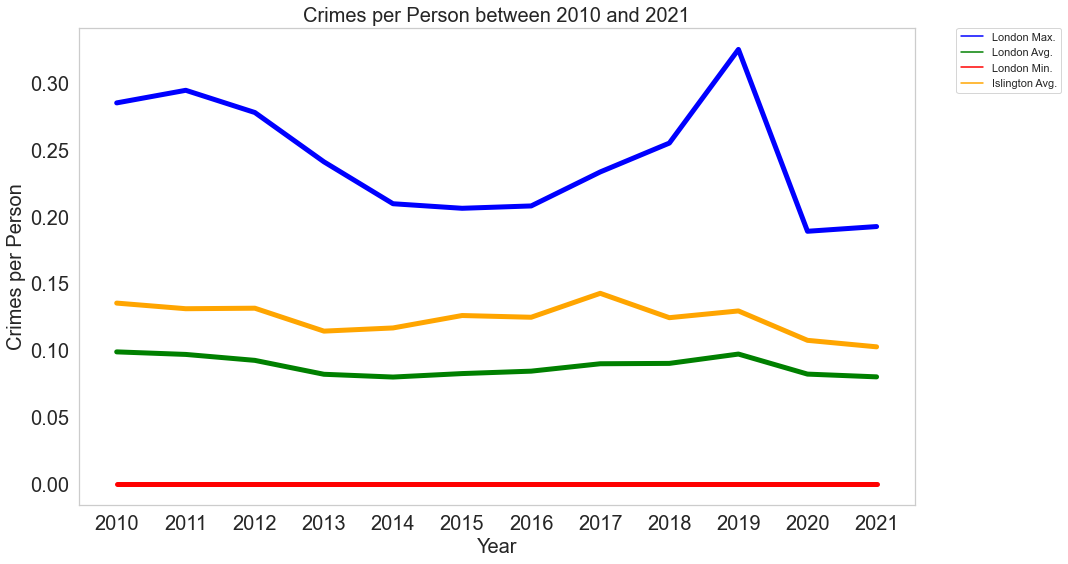

In [23]:
crime_plot

In [24]:
print(crime_narrative)


The 2021 crimes per person in Islington is 0.1025. This is above the average for London in the same period of 0.0800 and is below the maximum of 0.1926. It is above the minimum of 0.0000. Over the period 2010 to 2021 crimes per person in Islington has greatly decreasd. Over the same period the population of Islington has slightly increased starting at 202,849 and ending at 237,162  which is an increase of 34,313. London's population has slightly increased from 8,054,622 and ending at 9,417,134  which is an increase of 1,362,512.


In [25]:
log.debug(f"{borough}")

print(f"The table below shows the major crime category for {borough} within the period, first to fith with totals")

2022-08-21 21:43:47,517 [DEBUG] __main__: Islington
The table below shows the major crime category for Islington within the period, first to fith with totals


In [26]:
borough_major_crime_data_df_html

,1st,2nd,3rd,4th,5th
Year,,,,,
2010,"Theft - [7,159]","Violence Against the Person - [4,857]","Theft and Handling - [2,826]","Burglary - [2,614]","Vehicle Offences - [2,442]"
2011,"Theft - [10,145]","Violence Against the Person - [3,967]","Burglary - [2,812]","Vehicle Offences - [2,680]","Arson and Criminal Damage - [2,004]"
2012,"Theft - [11,139]","Violence Against the Person - [4,073]","Burglary - [2,414]","Vehicle Offences - [2,337]","Arson and Criminal Damage - [1,833]"
2013,"Theft - [9,905]","Violence Against the Person - [3,918]","Burglary - [2,408]","Vehicle Offences - [2,238]","Arson and Criminal Damage - [1,574]"
2014,"Theft - [8,868]","Violence Against the Person - [5,035]","Vehicle Offences - [2,394]","Burglary - [2,356]","Arson and Criminal Damage - [1,916]"
2015,"Theft - [9,990]","Violence Against the Person - [5,712]","Vehicle Offences - [2,441]","Burglary - [2,344]","Arson and Criminal Damage - [1,927]"
2016,"Theft - [9,666]","Violence Against the Person - [6,061]","Vehicle Offences - [2,391]","Burglary - [2,052]","Public Order Offences - [1,885]"
2017,"Theft - [12,638]","Violence Against the Person - [6,128]","Vehicle Offences - [2,992]","Burglary - [2,369]","Robbery - [1,790]"
2018,"Theft - [9,216]","Violence Against the Person - [6,441]","Vehicle Offences - [2,769]","Burglary - [2,736]","Public Order Offences - [1,649]"


In [27]:
print(crime_bump_chart_narrative)

How Islington ranks with the other London boroughs over the period 2010 to 2021 can be seen below. Ranking is top to bottom, with the top representing the highest crimes per person rate.


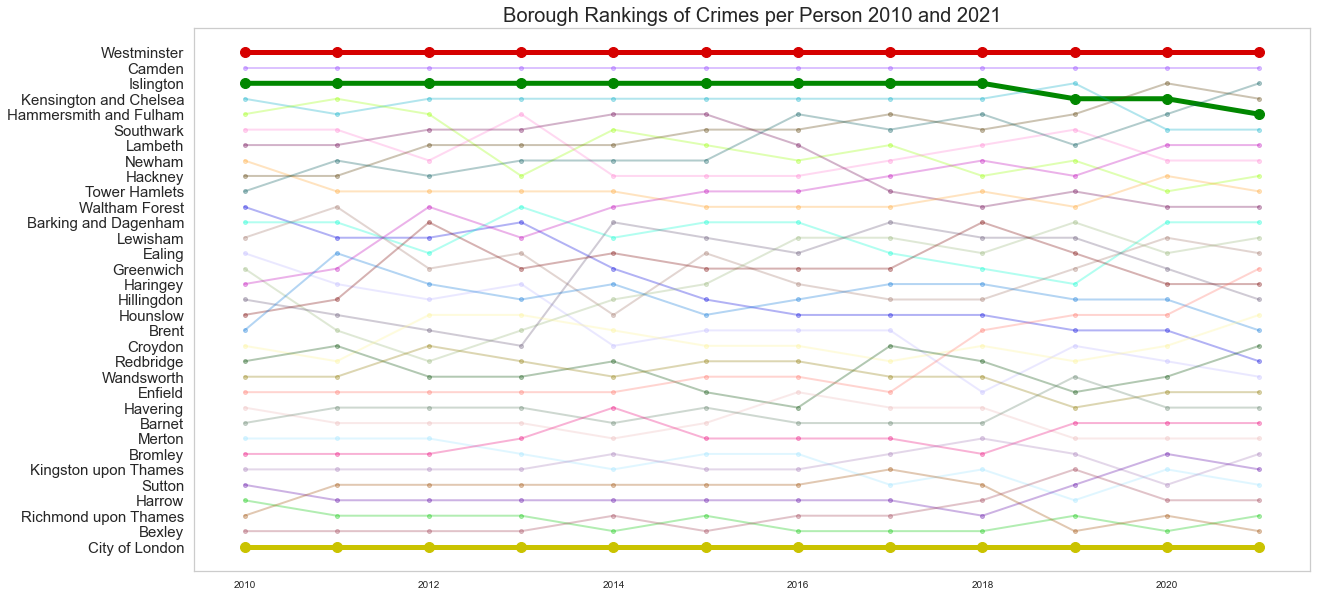

In [28]:
crime_bump_plot

In [29]:
crime_benchamark_data_df_html

,Borough with Lowest Crime per Person,Borough with Highest Crime per Person
Year,,
2021,City of London - 0.0000,Westminster - 0.1926
2020,City of London - 0.0000,Westminster - 0.1890
2019,City of London - 0.0000,Westminster - 0.3253
2018,City of London - 0.0000,Westminster - 0.2551
2017,City of London - 0.0000,Westminster - 0.2335
2016,City of London - 0.0000,Westminster - 0.2080
2015,City of London - 0.0000,Westminster - 0.2063
2014,City of London - 0.0000,Westminster - 0.2097
2013,City of London - 0.0000,Westminster - 0.2411


In [30]:
print("Crime by borough benchmark table")

Crime by borough benchmark table
